In [1]:
import sys
import json
import torch
import tensorboardX
import pandas as pd
from pathlib import Path
import plotly.express as px
from datetime import datetime
from typing import List, Iterator
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.ticker as tick


# import locals
sys.path.insert(0, str(Path('..').resolve()))
from tlaloc import EarningsGRUModel
from tlaloc import EarningsDataModule, SeqDataset

In [2]:
trnsf_path = Path('../outputs/model/params.json').resolve()
model_path = Path('../outputs/model/model.pth').resolve()

behind = 90
forward = 14

In [3]:
with open(trnsf_path, 'r') as f:
    meta = json.load(f)
print(json.dumps(meta, indent=4))

{
    "model": {
        "input_dim": 1,
        "hidden_dim": 32,
        "num_layers": 2,
        "output_dim": 1,
        "lr": 0.01
    },
    "data": {
        "min": 271671.588898111,
        "max": 524105.5617281316,
        "window": 100
    }
}


In [4]:
model = EarningsGRUModel(**meta['model'])
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [63]:
data = EarningsDataModule.load('../data/earnings.parquet')
seq = torch.FloatTensor(data[int(-behind*1.5):])
seq_adj = SeqDataset.scale(seq, meta['data']['min'], meta['data']['max'])

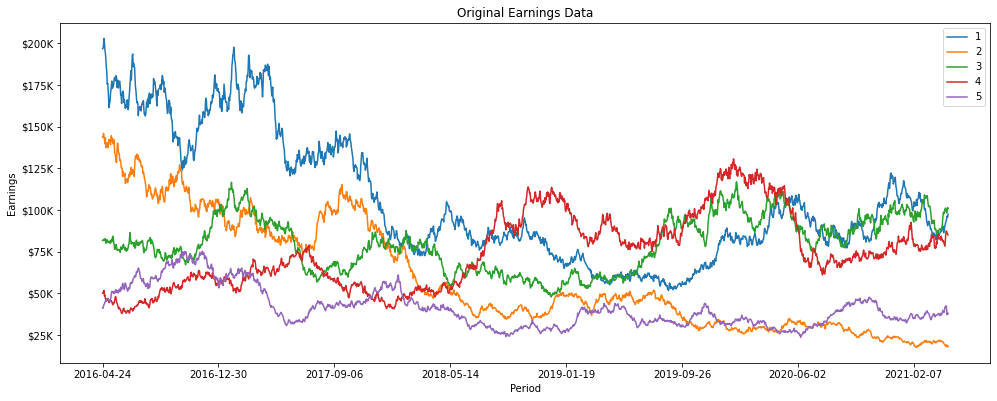

In [93]:
dataframe = pd.read_parquet('../data/earnings.parquet')
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
for key, grp in df.groupby(['resource_id']):
    ax = grp.plot(ax=ax, kind='line', x='date', y='earnings', label=key)

ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, p: '${:1.0f}K'.format(x/1000.)))
leg = ax.legend()
plt.title(f'Original Earnings Data')
plt.xlabel('Period')
plt.ylabel('Earnings')
plt.show()

In [94]:
df2 = df.groupby('date')['earnings'].sum().reset_index(name='earnings')
print(df2)

fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
ax.plot(df2['date'], df2['earnings'], color='blue', label='actual')
ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, p: '${:1.0f}K'.format(x/1000.)))
leg = ax.legend()
plt.title(f'Sequence Prediction [Back: {behind}, Forward: {forward}]')
plt.xlabel('Period')
plt.ylabel('Earnings')
plt.show()


            date       earnings
0     2016-04-24  514173.999405
1     2016-04-25  513958.656787
2     2016-04-26  520776.773935
3     2016-04-27  524105.561728
4     2016-04-28  518169.078667
...          ...            ...
1820  2021-04-18  341644.017838
1821  2021-04-19  339608.711596
1822  2021-04-20  337593.772238
1823  2021-04-21  340009.938993
1824  2021-04-22  339467.663898

[1825 rows x 2 columns]


KeyboardInterrupt: 

In [ ]:


for key, grp in df.groupby(['resource_id']):
    ax = grp.plot(ax=ax, kind='line', x='date', y='earnings', label=key)

ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, p: '${:1.0f}K'.format(x/1000.)))
leg = ax.legend()
plt.title(f'Original Earnings Data')
plt.xlabel('Period')
plt.ylabel('Earnings')
plt.show()

fig = px.line(df2, y="earnings")
fig.update_layout(title=f'Sum', xaxis_title='date', yaxis_title='earnings', width=960)
fig.show()

In [8]:
df3 = df2['earnings'].values

In [9]:
fig = px.line(df3, y=0)
fig.update_layout(title=f'Sum', xaxis_title='date', yaxis_title='earnings', width=960)
fig.show()

In [10]:
#import torch, gc
#gc.collect()
#torch.cuda.empty_cache()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
import numpy as np
seq_test = torch.FloatTensor(np.array([i for i in range(10)]))
print(seq_test)
win, lookahead = 3, 4

overlap = []
for i in reversed(range(1, lookahead+1)):
    print(i, seq_test[-win-i:-i])
    overlap.append(float(i))

print('overlap:', overlap)

test_inputs = list(seq_test[-win:].numpy())
print('prediction:', test_inputs)
for i in range(lookahead):
    print(i, test_inputs[-win:])
    test_inputs.append(float(i))

print(test_inputs)
print(test_inputs[-lookahead:])


tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
4 tensor([3., 4., 5.])
3 tensor([4., 5., 6.])
2 tensor([5., 6., 7.])
1 tensor([6., 7., 8.])
overlap: [4.0, 3.0, 2.0, 1.0]
prediction: [7.0, 8.0, 9.0]
0 [7.0, 8.0, 9.0]
1 [8.0, 9.0, 0.0]
2 [9.0, 0.0, 1.0]
3 [0.0, 1.0, 2.0]
[7.0, 8.0, 9.0, 0.0, 1.0, 2.0, 3.0]
[0.0, 1.0, 2.0, 3.0]


In [13]:

def predict(seq: torch.Tensor, window: int, lookbehind: int, lookahead: int) -> List:
    overlap = []
    predixn = list(seq[-window:].numpy())
    with torch.no_grad():
        model.to(device)
        model.eval()
        # get previous lookahead period (overlap)
        for i in reversed(range(1, lookbehind+1)):
            x = torch.FloatTensor(seq[-window-i:-i]).view(1, -1)
            y = model(x.to(device))
            overlap.append(y.detach().cpu().item())

        # begin future lookahead period (predictions)
        for i in range(lookahead):
            x = torch.FloatTensor(predixn[-window:]).view(1, -1)
            y = model(x.to(device))
            predixn.append(y.detach().cpu().item())

    return overlap + predixn[-lookahead:]

In [14]:
#p_seq = predict(seq_adj, meta['data']['window'], behind, forward)
p_seq = model.predict(list(seq_adj.numpy()), meta['data']['window'], behind, forward)

In [54]:
dmin, dmax = meta['data']['min'], meta['data']['max']
actual = SeqDataset.inverse_scale(seq_adj, dmin, dmax)
predicted = SeqDataset.inverse_scale(torch.FloatTensor(p_seq), dmin, dmax)


seq_size = seq_adj.size(0)
actual_range = [i for i in range(seq_size)]
pr = (seq_size-behind-1,seq_size+forward-1)
pred_range = [i for i in range(pr[0], pr[1])]
print(f'bd/fwd:        {behind}/{forward}')
print(f'seq sz:        {seq_size}')
print(f'seq range:     {range(seq_size)}, max: {actual_range[-1]}')
print(f'pred sz:       {predicted.size(0)}')
print(f'pred range:    {range(pr[0], pr[1])}, max: {pred_range[-1]}, min: {pred_range[0]}')
print(f'pred range sz: {pr[1] - pr[0]}')



bd/fwd:        90/14
seq sz:        135
seq range:     range(0, 135), max: 134
pred sz:       104
pred range:    range(44, 148), max: 147, min: 44
pred range sz: 104


In [55]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=actual_range, y=actual.numpy(), mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=pred_range, y=predicted.numpy(), mode='lines', name='Prediction'))
fig.update_layout(title=f'Earnings Prediction',
                   xaxis_title='Day',
                   yaxis_title='Scaled Price', width=960)
fig.show()

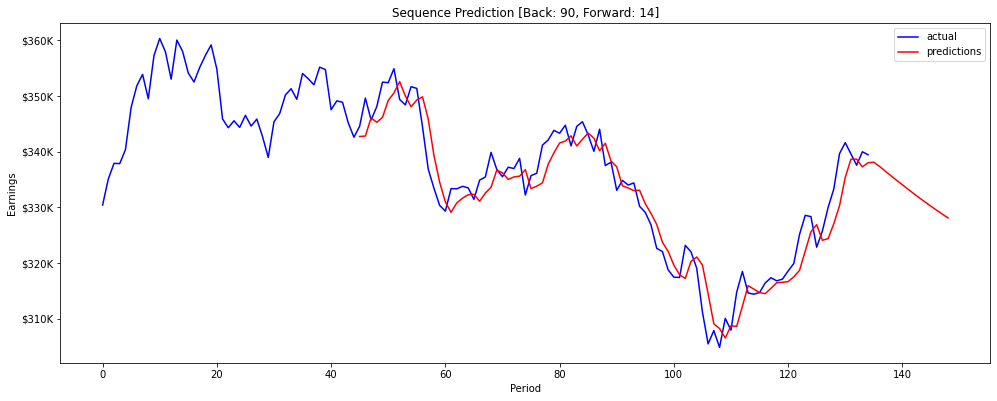

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

seq_size = seq_adj.size(0)
actual_range = [i for i in range(seq_size)]
pred_range = [i for i in range(seq_size-behind,seq_size+forward)]

dmin, dmax = meta['data']['min'], meta['data']['max']
actual = SeqDataset.inverse_scale(seq_adj, dmin, dmax)
predicted = SeqDataset.inverse_scale(torch.FloatTensor(p_seq), dmin, dmax)

fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
ax.plot(actual_range, actual, color='blue', label='actual')
ax.plot(pred_range, predicted, color='red', label='predictions')
ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, p: '${:1.0f}K'.format(x/1000.)))
leg = ax.legend()
plt.title(f'Sequence Prediction [Back: {behind}, Forward: {forward}]')
plt.xlabel('Period')
plt.ylabel('Earnings')
plt.show()
